## Table of Contents

* Data Set

* Defining a Baseline Model

* Deep Neural Networks
    * MLP
    * Convolutional Neural Networks (CNN)\
    https://stackoverflow.com/questions/49840968/valueerror-input-0-is-incompatible-with-layer-conv1d-1-expected-ndim-3-found
    
* What Is a Word Embedding?
     * One-Hot Encoding\
     https://stackoverflow.com/questions/50473381/scikit-learns-labelbinarizer-vs-onehotencoder
     * Keras Word Embedding\
     https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
     * Bert Sentence Embedding \
     https://github.com/UKPLab/sentence-transformers
     
* How To avoid Overfitting?
     * pooling\
     https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/
     * dropout\
     https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
     
* How To choose Loss Function and Laster Layer Activation Function? \
    * intro\
    https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/ \
    * code\
    https://www.dlology.com/blog/how-to-do-multi-class-multi-label-classification-for-news-categories/
    https://stackoverflow.com/questions/44164749/how-does-keras-handle-multilabel-classification
    * math \
    https://www.depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks/
    
*  Hyperparameters Optimization
    * k folder\
    https://machinelearningmastery.com/k-fold-cross-validation/ \
    * grid search\
    https://machinelearningmastery.com/how-to-grid-search-deep-learning-models-for-time-series-forecasting/
    * modle save \
    https://machinelearningmastery.com/check-point-deep-learning-models-keras/ \
    https://machinelearningmastery.com/save-load-keras-deep-learning-models/ \
    * early stop \
    https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

*  Imbalanced Dataset\
    https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/ \
    https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a \
    https://github.com/vinayakkailas/BERT_multilabel_text_classification
    

## Reference \



http://nlpprogress.com/english/relationship_extraction.html \
https://towardsdatascience.com/nlp-extract-contextualized-word-embeddings-from-bert-keras-tf-67ef29f60a7b \
https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b

* some reading:\
    * lstm and gru\
    https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21 \
    * f1 score\
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html \
    * begin state for multi label\
    https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/ \
    * filter words \
    https://stackoverflow.com/questions/42867002/filter-object-error-in-python-3 \
    https://stackoverflow.com/questions/32970204/filter-using-lambda-function-python \
    https://stackoverflow.com/questions/9953619/technique-to-remove-common-wordsand-their-plural-versions-from-a-string \
    
* NLP class: \
    * video from github\
    https://github.com/Developer-Y/cs-video-courses
    
    * berkeley \
    http://people.ischool.berkeley.edu/~dbamman/nlp20.html#info
    
* previous class project\
    * pet finder\
    https://github.com/apvitek/csmp240finalproject/blob/master/attempts/keras_multilayer_perceptron.ipynb \
    
    * label relations\
    http://scikit.ml/labelrelations.html
    
    * possible rescoures| continuing reading++++\
    https://github.com/vinayakkailas/BERT_multilabel_text_classification \
    https://github.com/CyberZHG/keras-word-char-embd \
    https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle \
    https://github.com/Neerajj9/Sentiment-Analysis-with-Word-Embeddings \
    






### Importing Packages
* Load the data with Pandas
* Creat `RELATIONS_NUM` in train for couting the number of relations in each sentence

In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from keras.callbacks import ModelCheckpoint, EarlyStopping
# !unzip ./data.zip
train = pd.read_csv('./data/hw1_train.csv')
test = pd.read_csv('./data/hw1_test.csv')
submission = pd.read_csv('./data/sampleSubmission.csv')
train.head()

Using TensorFlow backend.


,ID,UTTERANCE,CORE RELATIONS
0,0,who plays luke on star wars new hope,movie.starring.actor movie.starring.character
1,1,show credits for the godfather,movie.starring.actor
2,2,who was the main actor in the exorcist,movie.starring.actor
3,3,find the female actress from the movie she s t...,movie.starring.actor actor.gender
4,4,who played dory on finding nemo,movie.starring.actor movie.starring.character


## Training set 
{RangeIndex: 3338 entries, 0 to 3337}

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3338 entries, 0 to 3337
Data columns (total 3 columns):
ID                3338 non-null int64
UTTERANCE         3338 non-null object
CORE RELATIONS    3338 non-null object
dtypes: int64(1), object(2)
memory usage: 78.4+ KB


##  Preprocess
We found that each utterance may match several core relations, it means we need to predict:
    * how many relations for every utterance
    * for each one, what it is
    
**Simplify the problem** 

Make `every sentence` only match to `one single relation` in pandas

At the begining stage, we want to have one easy problem to start, so we want to narrow down to only one main relation for each utterance. This is not a big jump for this task, since the majority **(88.17%)** of utterance have one core relation. According to the train set, we select our single-label by it's probaility of the apperance. In this way, we always guess the one with high probability in our training set.



In order to reach our goal, we creat a dictionary for `relations` with `counts`, a dictionary for `multi_relations` with `counts`, and a dictionary for `replace_relations`.

,ID,UTTERANCE,CORE RELATIONS,RELATIONS_NUM,REPLACED_RELATION
0,0,who plays luke on star wars new hope,movie.starring.actor movie.starring.character,2,movie.starring.actor
1,1,show credits for the godfather,movie.starring.actor,1,movie.starring.actor
2,2,who was the main actor in the exorcist,movie.starring.actor,1,movie.starring.actor
3,3,find the female actress from the movie she s t...,movie.starring.actor actor.gender,2,movie.starring.actor
4,4,who played dory on finding nemo,movie.starring.actor movie.starring.character,2,movie.starring.actor


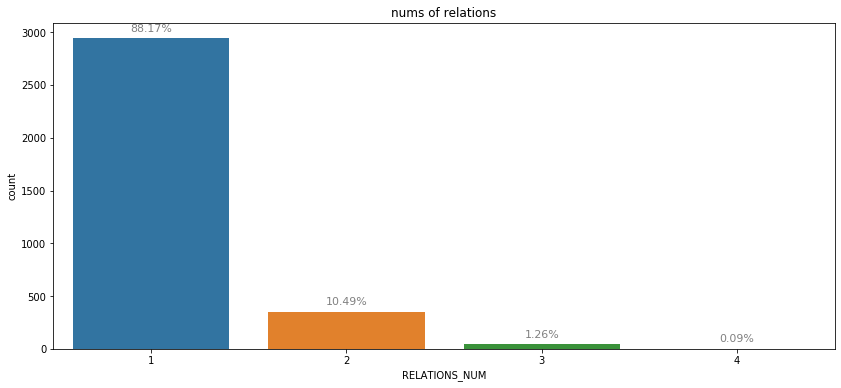

In [5]:
train['RELATIONS_NUM'] = 0
train['REPLACED_RELATION'] = ''
index_CORE_RELATIONS = train.columns.get_loc("CORE RELATIONS")
index_RELATIONS_NUM = train.columns.get_loc("RELATIONS_NUM")
index_REPLACED_RELATION = train.columns.get_loc("REPLACED_RELATION")

## creat relations_counts and multi_relations_counts
relations_counts = {}
multi_relations_counts = {}
for index, row in train.iterrows():

    relations = row['CORE RELATIONS'].split()
    train.iat[index,index_RELATIONS_NUM] = len(relations)
    
    # multi_relations_counts
    if len(relations) > 1:
        tuple_relations = tuple(sorted(relations))
        if tuple_relations not in multi_relations_counts:
            multi_relations_counts[tuple_relations] = 1
        else:
            multi_relations_counts[tuple_relations] += 1        

    # multi_relations_counts
    for word in relations:
        if word not in relations_counts:
            relations_counts[word] = 1
        else:
            relations_counts[word] += 1
            
# draw statistics graph
plt.figure(figsize=(14, 6));
g = sns.countplot(x='RELATIONS_NUM', data=train);
plt.title('nums of relations');
ax=g.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / train.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points')
        
## creat replace_relations
replace_relations = {}
for words in multi_relations_counts:
    words_counts = []
    for i in range(len(words)):
        words_counts.append(relations_counts[words[i]])
    m = max(words_counts)# chose max has better score but chose min  has diversity!
    for x, y in enumerate(words_counts):
        if y == m:
            replace_relations[words] = words[x]
            
## update on pandas           
for index, row in train.iterrows():
    relations = row['CORE RELATIONS'].split()
    tuple_relations = tuple(sorted(relations))
    if tuple_relations in replace_relations:
        train.iat[index,index_REPLACED_RELATION] = replace_relations[tuple_relations]
    else:
        train.iat[index,index_REPLACED_RELATION] = train.iat[index,index_CORE_RELATIONS]

train.head()

In [10]:
print('relations dictionay size : ' + str(len(relations_counts)))
print('multi_relations dictionay size : ' + str(len(multi_relations_counts)))
print('replace dictionay size : ' + str(len(replace_relations)))

relations dictionay size : 46
multi_relations dictionay size : 93
replace dictionay size : 93


In [11]:
pip install xlsxwriter

Note: you may need to restart the kernel to use updated packages.


In [12]:
##  show multi_relations_counts in sorted version

# {k: v for k, v in sorted(relations_counts.items(), key=lambda item: item[1],reverse = True)}
import xlsxwriter

workbook = xlsxwriter.Workbook('data.xlsx')
worksheet = workbook.add_worksheet()

d = relations_counts
row = 0
col = 0

for k, v in sorted(relations_counts.items(), key=lambda item: item[1],reverse = True):
    worksheet.write(row, col, k)
#     for item in d[key]:
    worksheet.write(row, col + 1, v)
    row += 1

workbook.close()

In [13]:
## ENCODER Example

# from numpy import array
# from numpy import argmax
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
# # define example
# data = ['cold', 'cold', 'warm', 'cold', 'hot', 'hot', 'warm', 'cold', 
# 'warm', 'hot']
# values = array(data)
# print ("Data: ", values)
# # integer encode
# label_encoder = LabelEncoder()
# integer_encoded = label_encoder.fit_transform(values)
# print ("Label Encoder:" ,integer_encoded)

# # onehot encode
# onehot_encoder = OneHotEncoder(sparse=False)
# integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
# onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
# print ("OneHot Encoder:", onehot_encoded)

# #Binary encode
# lb = LabelBinarizer()
# print ("Label Binarizer:", lb.fit_transform(values))

## ENCODER
* Data:  ['cold' 'cold' 'warm' 'cold' 'hot' 'hot' 'warm' 'cold' 'warm' 'hot']
    * Label Encoder: [0 0 2 0 1 1 2 0 2 1]
    * OneHot Encoder: [[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
    * Label Binarizer: [[1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 0]]
 
 In fact, you do not need to encode label for `LogisticRegression`, the model will handle the multilabel by itself (add **solver = 'lbfgs',multi_class='auto'**).

In [14]:

sentences = train['UTTERANCE'].values
y = train['REPLACED_RELATION'].values

LE_encoder = LabelEncoder().fit(y)
integer_encoded = LE_encoder.transform(y)

LB_encoder = LabelBinarizer().fit(y)
y_LB = LB_encoder.fit_transform(y)

integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
OH_encoder = OneHotEncoder(sparse=False,categories='auto').fit(integer_encoded)
y_OH = OH_encoder.fit_transform(integer_encoded)
vectorizer = CountVectorizer()
vectorizer.fit(sentences)




sentences_train, sentences_val, y_train, y_val, y_LB_train, y_LB_val, y_OH_train, y_OH_val \
            = train_test_split(sentences, y, y_LB, y_OH, test_size=0.2, random_state=1000)


X_train = vectorizer.transform(sentences_train)
X_val  = vectorizer.transform(sentences_val)
classifier = LogisticRegression(solver = 'lbfgs',multi_class='auto')
classifier.fit(X_train, y_train)
score = classifier.score(X_val, y_val)


print("Accuracy:", score)


Accuracy: 0.8532934131736527


`CountVectorizer` performs tokenization which separates the sentences into a set of **tokens**. It additionally removes punctuation and special characters and can apply other preprocessing to each word. If you want, you can use a custom tokenizer from the NLTK library with the CountVectorizer or use any number of the customizations which you can explore to improve the performance of your model.

In [35]:
print(y_OH[1])
print(integer_encoded)
print(y_LB[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[20]
 [20]
 [20]
 ...
 [ 3]
 [ 9]
 [ 3]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [15]:
# pip install -U imbalanced-learn

In [16]:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE('minority')
# X_train
# X_sm, y_sm = smote.fit_sample(X_train, y_train)
# print(X_sm.shape, y_sm.shape)


The classification model we are going to use is the logistic regression which is a simple yet powerful linear model that is mathematically speaking in fact a form of regression between 0 and 1 based on the input feature vector. By specifying a cutoff value (by default 0.5), the regression model is used for classification. 

## Output to csv file

In [17]:
!mkdir results
X_test = vectorizer.transform(test['UTTERANCE'].values)
submission_df = submission[["ID"]]
submission_df["CORE RELATIONS"] = classifier.predict(X_test)
submission_df.to_csv("./results/submission_logisticRegression.csv", index=False)
submission_df.tail()

mkdir: results: File exists


,ID,CORE RELATIONS
1079,1079,NO_REL
1080,1080,movie.starring.actor
1081,1081,movie.production_companies
1082,1082,movie.language
1083,1083,movie.country


## NN model

In [18]:
from keras.models import Sequential
from keras import layers
from sklearn.utils import class_weight
input_dim = X_train.shape[1]  # Number of features

class_weight = class_weight.compute_class_weight('balanced' ,np.unique(y_train) ,y_train)

filepath = "./model.hdf_MLP"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystopped = EarlyStopping(monitor='val_loss', mode='min', patience=10)
callbacks_list = [earlystopped, checkpoint]

model = Sequential()
# model.add(layers.Dense(200, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(100, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(35, activation='softmax'))# 35 for max; 44 for using min as choice in replace_relation
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_OH_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_val, y_OH_val),
                    batch_size=10,
                    class_weight=class_weight,
                    callbacks=callbacks_list)






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               169400    
_________________________________________________________________
dense_2 (Dense)              (None, 35)                3535      
Total params: 172,935
Trainable params: 172,935
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2670 samples, validate on 668 samples
Epoch 1/50





2670/2670 [==============================] - 3s 1ms/step - loss: 2.5205 - acc: 0.4026 - val_loss: 1.5932 - val_acc: 0.6796

Epoch 00001: val_acc improved from -inf to 0.67964, saving model to ./model.hdf_MLP
Epoch 2/50
2670/2670 [==============================] - 2s 820us/step - loss: 1.1604 - acc: 0.7588 - val_loss: 0.9562 - val_acc: 0.7829

Epoch 00002: val_acc i

In [36]:
loss, accuracy = model.evaluate(X_train, y_OH_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val, y_OH_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9978
Testing Accuracy:  0.8638


In [37]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

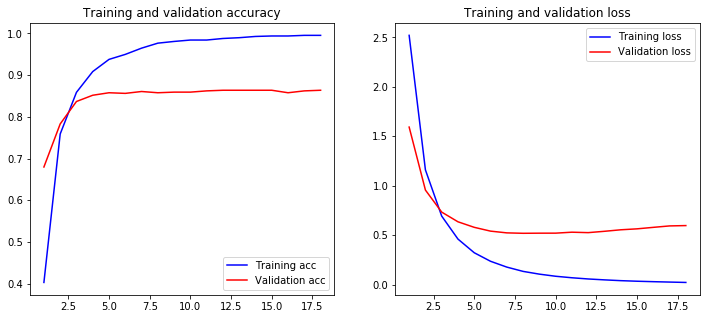

In [38]:
plot_history(history)

In [39]:
model.load_weights("./model.hdf_MLP")

Predictions = OH_encoder.inverse_transform(model.predict(X_test)).ravel()
submission_df["CORE RELATIONS"] = LE_encoder.inverse_transform(Predictions)
submission_df.to_csv("./results/submission_keras_MLP.csv", index=False)
submission_df.tail()

,ID,CORE RELATIONS
1079,1079,movie.trailer
1080,1080,movie.rating
1081,1081,movie.production_companies
1082,1082,movie.initial_release_date
1083,1083,movie.country


In [40]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

In [43]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(sentences)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_val = tokenizer.texts_to_sequences(sentences_val)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = 15

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
print(sentences_train[2])
print(X_train[2])


give me more details about the producer ray stark
[ 86   7 115 129  19   1  62 206 220   0   0   0   0   0   0]


In [44]:

print(X_train[0])

[ 46 107  32   0   0   0   0   0   0   0   0   0   0   0   0]


In [26]:
embedding_dim = 100
filepath = "./model.hdf_embeding"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystopped = EarlyStopping(monitor='val_loss', mode='min', patience=10)
callbacks_list = [earlystopped, checkpoint]
# class_weight = class_weight.compute_class_weight('balanced' ,np.unique(y_train) ,y_train) 
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
# model.add(layers.Flatten())
model.add(layers.GlobalMaxPool1D())
#Global max/average pooling takes the maximum/average of 
# all features whereas in the other case you have to define the pool size.
# model.add(layers.Dense(200, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(35, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 15, 128)           226176    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 35)                4515      
Total params: 230,691
Trainable params: 230,691
Non-trainable params: 0
_________________________________________________________________


In [27]:
len(y_OH_val)

668

In [28]:
history = model.fit(X_train, y_OH_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_val, y_OH_val),
                    batch_size=10,
                    class_weight=class_weight,
                    callbacks = callbacks_list )
loss, accuracy = model.evaluate(X_train, y_OH_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val, y_OH_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Train on 2670 samples, validate on 668 samples
Epoch 1/50
2670/2670 [==============================] - 4s 1ms/step - loss: 2.9363 - acc: 0.2139 - val_loss: 2.5380 - val_acc: 0.2964

Epoch 00001: val_acc improved from -inf to 0.29641, saving model to ./model.hdf_embeding
Epoch 2/50
2670/2670 [==============================] - 2s 881us/step - loss: 2.1568 - acc: 0.4715 - val_loss: 1.7784 - val_acc: 0.6198

Epoch 00002: val_acc improved from 0.29641 to 0.61976, saving model to ./model.hdf_embeding
Epoch 3/50
2670/2670 [==============================] - 2s 866us/step - loss: 1.3936 - acc: 0.7142 - val_loss: 1.2035 - val_acc: 0.7216

Epoch 00003: val_acc improved from 0.61976 to 0.72156, saving model to ./model.hdf_embeding
Epoch 4/50
2670/2670 [==============================] - 2s 932us/step - loss: 0.9582 - acc: 0.7981 - val_loss: 0.9309 - val_acc: 0.8009

Epoch 00004: val_acc improved from 0.72156 to 0.80090, saving model to ./model.hdf_embeding
Epoch 5/50
2670/2670 [====================

,ID,CORE RELATIONS
1079,1079,movie.initial_release_date
1080,1080,movie.starring.actor
1081,1081,movie.production_companies
1082,1082,movie.directed_by
1083,1083,movie.country


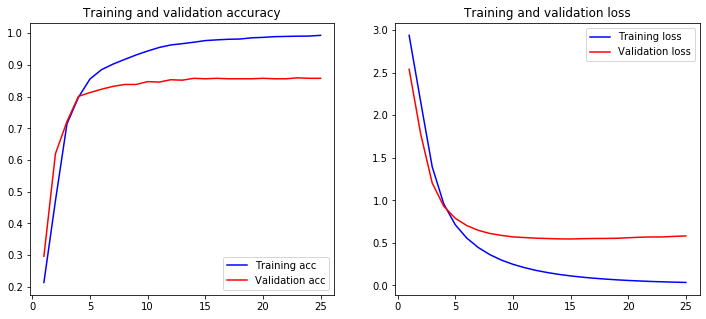

In [29]:
plot_history(history)
X_test = tokenizer.texts_to_sequences(test['UTTERANCE'].values)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
model.load_weights("./model.hdf_embeding")

Predictions = OH_encoder.inverse_transform(model.predict(X_test)).ravel()
submission_df["CORE RELATIONS"] = LE_encoder.inverse_transform(Predictions)
submission_df.to_csv("./results/submission_keras_embeding.csv", index=False)
submission_df.tail()


In [30]:
embedding_dim = 300
filepath = "./model.hdf_cnn"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystopped = EarlyStopping(monitor='val_loss', mode='min', patience=10)
callbacks_list = [earlystopped, checkpoint]
class_weight = class_weight.compute_class_weight('balanced' ,np.unique(y_train) ,y_train)
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(35, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

AttributeError: 'numpy.ndarray' object has no attribute 'compute_class_weight'

In [ ]:
history = model.fit(X_train, y_OH_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_val, y_OH_val),
                    batch_size=10,
                    class_weight=class_weight,
                    callbacks = callbacks_list)

loss, accuracy = model.evaluate(X_train, y_OH_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val, y_OH_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
plot_history(history)
# X_test = tokenizer.texts_to_sequences(test['UTTERANCE'].values)
# X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
model.load_weights("./model.hdf_cnn")
submission_df = submission[["ID"]]
Predictions = OH_encoder.inverse_transform(model.predict(X_test)).ravel()
submission_df["CORE RELATIONS"] = LE_encoder.inverse_transform(Predictions)
submission_df.to_csv("./results/submission_keras_cnn.csv", index=False)
submission_df.tail()


In [ ]:
# from keras.optimizers import SGD
# sgd = SGD(lr=0.001, decay=1e-6, momentum=0.8, nesterov=True)

In [ ]:
# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')
# s=set(stopwords.words('english'))

# txt = "hahah you are the big peopel ."
# text = filter(lambda w: not w in s,txt.split())
# text = list(text)

In [ ]:
# print(text)

Kaggle score:
LogisticRegression 0.76\
MLP 0.77\
embeding 0.807\
Cnn 0.77


In [31]:
from sklearn.preprocessing import MultiLabelBinarizer
Labels = [ k for k in relations_counts]
mlb = MultiLabelBinarizer(sparse_output=False,classes=None).fit([Labels])
# mlb.classes_
x = []
for i in y:
    x.append(tuple(i.split()))
y_label = mlb.transform(x)

LE_encoder = LabelEncoder().fit(y)
integer_encoded = LE_encoder.transform(y)

LB_encoder = LabelBinarizer().fit(y)
y_LB = LB_encoder.fit_transform(y)

integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
OH_encoder = OneHotEncoder(sparse=False,categories='auto').fit(integer_encoded)
y_OH = OH_encoder.fit_transform(integer_encoded)

sentences_train, sentences_val, y_train, y_val, y_OH_train, y_OH_val = train_test_split(sentences, y_label, y_OH, test_size=0.25, random_state=1000)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_val = tokenizer.texts_to_sequences(sentences_val)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

In [32]:
mlb.classes_

array(['NO_REL', 'actor.gender', 'actor.nationality', 'award.category',
       'award.ceremony', 'award.winning_work', 'director.award',
       'director.nationality', 'gr.amount', 'movie.award',
       'movie.award_nom', 'movie.country', 'movie.description',
       'movie.directed_by', 'movie.estimated_budget', 'movie.genre',
       'movie.gross_revenue', 'movie.initial_release_date',
       'movie.language', 'movie.locations', 'movie.media', 'movie.music',
       'movie.produced_by', 'movie.production_companies', 'movie.rating',
       'movie.release', 'movie.review', 'movie.runtime', 'movie.showing',
       'movie.star_rating', 'movie.starring.actor',
       'movie.starring.character', 'movie.subjects', 'movie.synopsis',
       'movie.trailer', 'movie.written_by', 'movie_other', 'other',
       'person.award', 'person.country', 'person.date_of_birth',
       'person.nationality', 'person.picture', 'release.date',
       'release.region', 'rt.runtime'], dtype=object)

In [33]:
embedding_dim = 200
filepath = "./model.hdf_embeding_multi"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystopped = EarlyStopping(monitor='val_loss', mode='min', patience=10)
callbacks_list = [earlystopped, checkpoint]

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
# model.add(layers.Flatten())
model.add(layers.GlobalMaxPool1D())
#Global max/average pooling takes the maximum/average of 
# all features whereas in the other case you have to define the pool size.
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(46, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 200)          353400    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               25728     
_________________________________________________________________
dense_8 (Dense)              (None, 46)                5934      
Total params: 385,062
Trainable params: 385,062
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose= True,
                    validation_data=(X_val, y_val),
                    batch_size=5,
                    callbacks = callbacks_list)

Train on 2503 samples, validate on 835 samples
Epoch 1/50
2503/2503 [==============================] - 11s 4ms/step - loss: 0.1200 - acc: 0.9730 - val_loss: 0.0796 - val_acc: 0.9783

Epoch 00001: val_acc improved from -inf to 0.97826, saving model to ./model.hdf_embeding_multi
Epoch 2/50
2503/2503 [==============================] - 11s 5ms/step - loss: 0.0681 - acc: 0.9799 - val_loss: 0.0506 - val_acc: 0.9829

Epoch 00002: val_acc improved from 0.97826 to 0.98287, saving model to ./model.hdf_embeding_multi
Epoch 3/50
2503/2503 [==============================] - 11s 4ms/step - loss: 0.0394 - acc: 0.9878 - val_loss: 0.0341 - val_acc: 0.9894

Epoch 00003: val_acc improved from 0.98287 to 0.98938, saving model to ./model.hdf_embeding_multi
Epoch 4/50
2503/2503 [==============================] - 11s 4ms/step - loss: 0.0262 - acc: 0.9918 - val_loss: 0.0270 - val_acc: 0.9917

Epoch 00004: val_acc improved from 0.98938 to 0.99172, saving model to ./model.hdf_embeding_multi
Epoch 5/50
2503/2503

Training Accuracy: 0.9999
Testing Accuracy:  0.9940


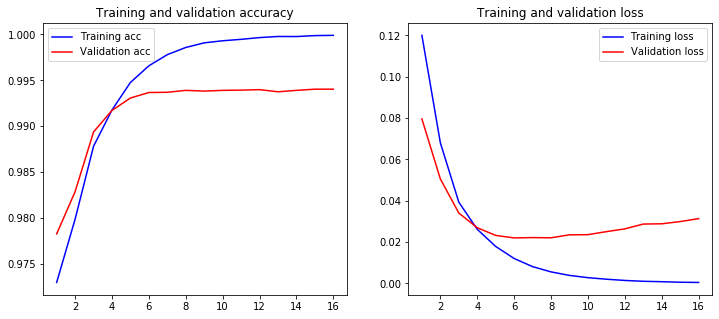

In [35]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [36]:
from sklearn.metrics import f1_score
model.load_weights("./model.hdf_embeding_multi")
TOKENsentences = tokenizer.texts_to_sequences(sentences)
X_TOKENsentences = pad_sequences(TOKENsentences, padding='post', maxlen=maxlen)
train2 = pd.read_csv('./data/hw1_train.csv')

In [37]:
threshold = 0.2;
maxScore = 0;

for x in range(40):
    probas = model.predict(X_TOKENsentences)
    index = 0
    for i in probas:
        probas[index] = (i > 0.1+(x/100)).astype(np.int)
    #0.23
        index = index+1
    
    train2_df = train2[["ID"]]
    train2_df.loc[:,"CORE RELATIONS"] = mlb.inverse_transform(probas)
    train2_df.loc[:,"CORE RELATIONS"] = train2_df.loc[:,"CORE RELATIONS"].map(' '.join)
#     train2_df.loc[:,"CORE RELATIONS"]= train2_df.loc[:,"CORE RELATIONS"].replace('', 'NO_REL')
    if maxScore < f1_score(train["CORE RELATIONS"], train2_df["CORE RELATIONS"], average='weighted'):
        maxScore = f1_score(train["CORE RELATIONS"], train2_df["CORE RELATIONS"], average='weighted')
        threshold = 0.1 + x/100
        
print(threshold)
print(maxScore)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0.49
0.8057105827314396


In [38]:
X_test = tokenizer.texts_to_sequences(test['UTTERANCE'].values)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

probas1 = model.predict(X_test)
index = 0
for i in probas1:
    probas1[index] = (i > threshold).astype(np.int)
    #0.23
    index = index+1

In [39]:
submission_df = submission[["ID"]]
submission_df["CORE RELATIONS"] = mlb.inverse_transform(probas1)
submission_df["CORE RELATIONS"] = submission_df["CORE RELATIONS"].map(' '.join)
# submission_df["CORE RELATIONS"]= submission_df["CORE RELATIONS"].replace('', 'NO_REL') # movie.directed_by
submission_df.to_csv("./results/submission_keras_embeding_multi.csv", index=False)

In [40]:
submission_df.tail()

,ID,CORE RELATIONS
1079,1079,
1080,1080,
1081,1081,movie.initial_release_date
1082,1082,movie.starring.actor
1083,1083,


In [48]:
!pip install sentence-transformers

     |████████████████████████████████| 51kB 1.9MB/s 
     |████████████████████████████████| 450kB 8.6MB/s 
     |████████████████████████████████| 1.0MB 33.4MB/s 
     |████████████████████████████████| 870kB 40.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.5-cp36-none-any.whl size=64942 sha256=82d72536ee1c799fd18906dd6ca3be65ba7c6ea100dbcb885946d3247cfbcec2
  Stored in directory: /root/.cache/pip/wheels/b4/ce/39/5bbda8ac34eb52df8c6531382ca077773fbfcbfb6386e5d66c
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=7a9d82203849efc89a5c90b993b70a090e8c0e26d049fea9b31fcc78cc1c6c6a
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sentence-transformers sacremoses


In [49]:
from sentence_transformers import SentenceTransformer
Bertmodel = SentenceTransformer('bert-base-nli-mean-tokens')
# sentence_embeddings = Bertmodel.encode(sentences)

100%|██████████| 405M/405M [01:05<00:00, 6.22MB/s]


In [0]:
sentences_train = Bertmodel.encode(sentences_train)
sentences_val = Bertmodel.encode(sentences_val)
sentences_train = np.asarray(sentences_train)
sentences_val = np.asarray(sentences_val)
X_train = sentences_train
X_val = sentences_val

In [51]:
from keras.layers import Dropout
from keras.constraints import maxnorm
embedding_dim = 512
filepath = "./model.hdf_bert_multi"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystopped = EarlyStopping(monitor='val_loss', mode='min', patience=10)
callbacks_list = [earlystopped, checkpoint]

model = Sequential()
model.add(layers.Dense(512, input_dim=768, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(128, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.3))
model.add(layers.Dense(46, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               393728    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 46)                5934      
Total params: 465,326
Trainable params: 465,326
Non-trainable params: 0
_________________________________________________________________


Train on 2503 samples, validate on 835 samples
Epoch 1/50
2503/2503 [==============================] - 5s 2ms/step - loss: 0.0872 - acc: 0.9722 - val_loss: 0.0454 - val_acc: 0.9836

Epoch 00001: val_acc improved from -inf to 0.98357, saving model to ./model.hdf_bert_multi
Epoch 2/50
2503/2503 [==============================] - 5s 2ms/step - loss: 0.0457 - acc: 0.9847 - val_loss: 0.0359 - val_acc: 0.9875

Epoch 00002: val_acc improved from 0.98357 to 0.98753, saving model to ./model.hdf_bert_multi
Epoch 3/50
2503/2503 [==============================] - 5s 2ms/step - loss: 0.0363 - acc: 0.9879 - val_loss: 0.0310 - val_acc: 0.9896

Epoch 00003: val_acc improved from 0.98753 to 0.98964, saving model to ./model.hdf_bert_multi
Epoch 4/50
2503/2503 [==============================] - 5s 2ms/step - loss: 0.0310 - acc: 0.9895 - val_loss: 0.0274 - val_acc: 0.9907

Epoch 00004: val_acc improved from 0.98964 to 0.99073, saving model to ./model.hdf_bert_multi
Epoch 5/50
2503/2503 [==================

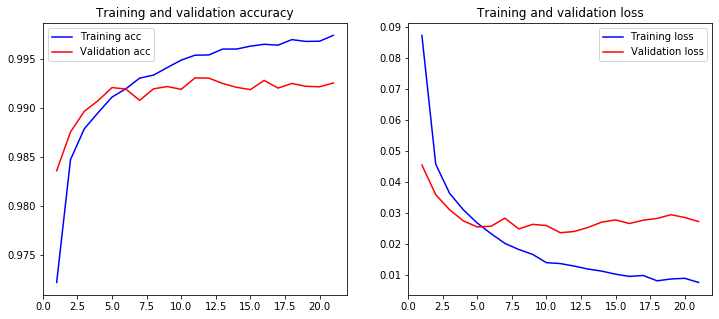

In [52]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_val, y_val),
                    batch_size=5,
                    callbacks = callbacks_list )
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [53]:
X_test = Bertmodel.encode(test['UTTERANCE'].values)
X_test = np.asarray(X_test)
model.load_weights("./model.hdf_bert_multi")
X_TOKENsentences = Bertmodel.encode(sentences)
X_TOKENsentences = np.asarray(X_TOKENsentences)
threshold = 0.2;
maxScore = 0;

for x in range(40):
    probas = model.predict(X_TOKENsentences)
    index = 0
    for i in probas:
        probas[index] = (i > 0.1+(x/100)).astype(np.int)
    #0.23
        index = index+1
    
    train2_df = train2[["ID"]]
    train2_df.loc[:,"CORE RELATIONS"] = mlb.inverse_transform(probas)
    train2_df.loc[:,"CORE RELATIONS"] = train2_df.loc[:,"CORE RELATIONS"].map(' '.join)
#     train2_df.loc[:,"CORE RELATIONS"]= train2_df.loc[:,"CORE RELATIONS"].replace('', 'NO_REL')
    if maxScore < f1_score(train["CORE RELATIONS"], train2_df["CORE RELATIONS"], average='weighted'):
        maxScore = f1_score(train["CORE RELATIONS"], train2_df["CORE RELATIONS"], average='weighted')
        threshold = 0.1 + x/100
        
print(threshold)
print(maxScore)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0.44000000000000006
0.7715801362011383


In [0]:
probas1 = model.predict(X_test)
index = 0
for i in probas1:
    probas1[index] = (i > threshold).astype(np.int)
    #0.23
    index = index+1

In [55]:
submission_df = submission[["ID"]]
submission_df["CORE RELATIONS"] = mlb.inverse_transform(probas1)
submission_df["CORE RELATIONS"] = submission_df["CORE RELATIONS"].map(' '.join)
# submission_df["CORE RELATIONS"]= submission_df["CORE RELATIONS"].replace('', 'NO_REL') # movie.directed_by
submission_df.to_csv("./results/submission_keras_bert_multi.csv.csv", index=False)
submission_df.tail()

,ID,CORE RELATIONS
1079,1079,NO_REL movie.trailer
1080,1080,
1081,1081,movie.initial_release_date
1082,1082,
1083,1083,movie.country


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               393728    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 35)                4515      
Total params: 463,907
Trainable params: 463,907
Non-trainable params: 0
_________________________________________________________________
Train on 2503 samples, validate on 835 samples
Epoch 1/50
2503/2503 [==============================] - 5s 2ms/step - loss: 1.7873 - acc: 0.4858 - val_loss: 1.1544 - val_acc: 0.6886

Epoch 00001: val_acc improved from -inf to 0.68862, saving model

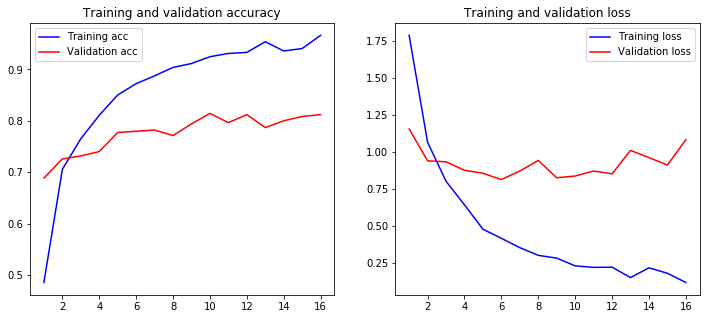

In [56]:
embedding_dim = 512
filepath = "./model.hdf_bert_single"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystopped = EarlyStopping(monitor='val_loss', mode='min', patience=10)
callbacks_list = [earlystopped, checkpoint]

model = Sequential()
model.add(layers.Dense(512, input_dim=768, activation='relu'))
model.add(layers.Dense(128, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.3))
model.add(layers.Dense(35, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_OH_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_val, y_OH_val),
                    batch_size=5,
                    callbacks = callbacks_list )
loss, accuracy = model.evaluate(X_train, y_OH_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val, y_OH_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [0]:
model.load_weights("./model.hdf_bert_single")
X_test = Bertmodel.encode(test['UTTERANCE'].values)
X_test = np.asarray(X_test)

In [59]:
Predictions = OH_encoder.inverse_transform(model.predict(X_test)).ravel()
submission_df["CORE RELATIONS"] = LE_encoder.inverse_transform(Predictions)
submission_df.to_csv("./results/submission_keras_bert_single.csv", index=False)
submission_df.tail()

,ID,CORE RELATIONS
1079,1079,movie.trailer
1080,1080,movie.directed_by
1081,1081,movie.initial_release_date
1082,1082,movie.estimated_budget
1083,1083,movie.country


In [60]:
!zip -r ./results.zip ./results/
from google.colab import files


  adding: results/ (stored 0%)
  adding: results/submission_keras_MLP.csv (deflated 84%)
  adding: results/submission_keras_bert_single.csv (deflated 84%)
  adding: results/submission_keras_embeding.csv (deflated 84%)
  adding: results/submission_keras_bert_multi.csv.csv (deflated 83%)
  adding: results/submission_keras_embeding_multi.csv (deflated 82%)
  adding: results/submission_logisticRegression.csv (deflated 84%)
  adding: results/submission_keras_cnn.csv (deflated 84%)


In [0]:
from sklearn.model_selection import RandomizedSearchCV

In [0]:
y = train['REPLACED_RELATION'].values

In [0]:
def create_model_embed(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(46, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def create_model_bert(embedding_dim, embedding_dim2):
    model = Sequential()
    model.add(layers.Dense(embedding_dim, input_dim=768, activation='relu'))
    model.add(layers.Dense(embedding_dim2, activation='relu'))
    model.add(layers.Dense(35, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Main settings
epochs = 50
embedding_dim = 50
maxlen = 100

print('Running grid search for data set :')
Labels = [ k for k in relations_counts]
mlb = MultiLabelBinarizer(sparse_output=False,classes=None).fit([Labels])
# mlb.classes_
x = []
for i in y:
    x.append(tuple(i.split()))
y_label = mlb.transform(x)

LE_encoder = LabelEncoder().fit(y)
integer_encoded = LE_encoder.transform(y)

LB_encoder = LabelBinarizer().fit(y)
y_LB = LB_encoder.fit_transform(y)

integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
OH_encoder = OneHotEncoder(sparse=False,categories='auto').fit(integer_encoded)
y_OH = OH_encoder.fit_transform(integer_encoded)

sentences_train, sentences_val, y_train, y_val, y_OH_train, y_OH_val = train_test_split(sentences, y_label, y_OH, test_size=0.25, random_state=1000)

########################embed
# Tokenize words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_val = tokenizer.texts_to_sequences(sentences_val)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences with zeros
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

# Parameter grid for grid search
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[vocab_size], 
                  embedding_dim=[200],
                  maxlen=[100])
    
model = KerasClassifier(build_fn=create_model_embed,
                            epochs=epochs, batch_size=10,
                            verbose=False)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)

grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_val, y_val)
s = ('Running data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
output_string = s.format(
        grid_result.best_score_,
        grid_result.best_params_,
        test_accuracy)
print(output_string)

########################bert


# Tokenize words
sentences_train = Bertmodel.encode(sentences_train)
sentences_val = Bertmodel.encode(sentences_val)
sentences_train = np.asarray(sentences_train)
sentences_val = np.asarray(sentences_val)
X_train = sentences_train
X_val = sentences_val


# Parameter grid for grid search
param_grid = dict(embedding_dim=[100, 150, 200],
                  embedding_dim2=[100, 150])
    
model = KerasClassifier(build_fn=create_model_bert,
                            epochs=epochs, batch_size=10,
                            verbose=False)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)

grid_result = grid.fit(X_train, y_OH_train)

# Evaluate testing set
test_accuracy = grid.score(X_val, y_OH_val)
s = ('Running data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
output_string = s.format(
        grid_result.best_score_,
        grid_result.best_params_,
        test_accuracy)
print(output_string)


Running grid search for data set :
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running data set
Best Accuracy : 0.9884
{'embedding_dim2': 100, 'embedding_dim': 100}
Test Accuracy : 0.9902




In [41]:
# def create_model_embed_multi(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
#     model = Sequential()
#     model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
#     model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
#     model.add(layers.GlobalMaxPooling1D())
#     model.add(layers.Dense(128, activation='relu'))
#     model.add(layers.Dense(46, activation='sigmoid'))
#     model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# def create_model_bert_multi(embedding_dim, embedding_dim2):
#     model = Sequential()
#     model.add(layers.Dense(embedding_dim, input_dim=768, activation='relu'))
#     model.add(layers.Dense(embedding_dim2, activation='relu'))
#     model.add(layers.Dense(46, activation='sigmoid'))
#     model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model


# # Main settings
# epochs = 50
# embedding_dim = 50
# maxlen = 100

# print('Running grid search for data set :')
# Labels = [ k for k in relations_counts]
# mlb = MultiLabelBinarizer(sparse_output=False,classes=None).fit([Labels])
# # mlb.classes_
# x = []
# for i in y:
#     x.append(tuple(i.split()))
# y_label = mlb.transform(x)
# # Train-test split
# sentences_train, sentences_val, y_train, y_val = train_test_split(
#         sentences, y_label, test_size=0.2, random_state=400)

# #################################################################################
# # Tokenize words
# tokenizer = Tokenizer(num_words=5000)
# tokenizer.fit_on_texts(sentences)
# X_train = tokenizer.texts_to_sequences(sentences_train)
# X_val = tokenizer.texts_to_sequences(sentences_val)

# # Adding 1 because of reserved 0 index
# vocab_size = len(tokenizer.word_index) + 1

# # Pad sequences with zeros
# X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

# # Parameter grid for grid search
# param_grid = dict(num_filters=[32, 64, 128],
#                   kernel_size=[3, 5, 7],
#                   vocab_size=[1000, 3000, 6000], 
#                   embedding_dim=[50,100,150],
#                   maxlen=[100])
    
# model = KerasClassifier(build_fn=create_model_embed_multi,
#                             epochs=epochs, batch_size=10,
#                             verbose=False)

# grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
#                               cv=4, verbose=1, n_iter=5)

# grid_result = grid.fit(X_train, y_train)

# # Evaluate testing set
# test_accuracy = grid.score(X_val, y_val)
# s = ('Running {} data set\nBest Accuracy : '
#              '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
# output_string = s.format(
#         source,
#         grid_result.best_score_,
#         grid_result.best_params_,
#         test_accuracy)
# print(output_string)


# #################################################################################
# # Tokenize words
# sentences_train = Bertmodel.encode(sentences_train)
# sentences_val = Bertmodel.encode(sentences_val)
# sentences_train = np.asarray(sentences_train)
# sentences_val = np.asarray(sentences_val)
# X_train = sentences_train
# X_val = sentences_val


# # Parameter grid for grid search
# param_grid = dict(embedding_dim=[50, 100, 150],
#                   embedding_dim2=[50, 100])
    
# model = KerasClassifier(build_fn=create_model_bert_multi,
#                             epochs=epochs, batch_size=10,
#                             verbose=False)

# grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
#                               cv=4, verbose=1, n_iter=5)

# grid_result = grid.fit(X_train, y_train)

# # Evaluate testing set
# test_accuracy = grid.score(X_val, y_val)
# s = ('Running {} data set\nBest Accuracy : '
#              '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
# output_string = s.format(
#         source,
#         grid_result.best_score_,
#         grid_result.best_params_,
#         test_accuracy)
# print(output_string)